<a href="https://colab.research.google.com/github/nelischalich/CS584-Seoul-Bike-Sharing/blob/Matiss/Initial_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial EDA

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
## Data import


file_path = '/content/SeoulBikeData.csv'

try:
    df = pd.read_csv(file_path, encoding='utf-8')
except UnicodeDecodeError:
    try:
        df = pd.read_csv(file_path, encoding='ISO-8859-1')
    except UnicodeDecodeError:
        df = pd.read_csv(file_path, encoding='cp1252')

print(df.head())
print(len(df))

         Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0  01/12/2017                254     0             -5.2           37   
1  01/12/2017                204     1             -5.5           38   
2  01/12/2017                173     2             -6.0           39   
3  01/12/2017                107     3             -6.2           40   
4  01/12/2017                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Winter  No Holiday   


So we find that for all instances where no bikes were rented out the service was not operational. We may remove the entire day or just the hourly observations where we see no bikes rented as these observations shouldn't influence our model. This is shown Below

In [27]:
#### Check for days where no bikes were taken out

no_bikes_mask = df[df['Rented Bike Count'] == 0]

print(f"There are {len(no_bikes_mask)} hours where no bikes were used")

intersect_no_bikes_and_operational = no_bikes_mask[no_bikes_mask['Functioning Day'] == 'No']

print(f"For {len(intersect_no_bikes_and_operational)} of those hours the service was not operational")

There are 295 hours where no bikes were used
For 295 of those hours the service was not operational


### Graph of daily bike usage

We create an aggregate by hours for each day to visualize how the usage changes day to day and any daily or seasonal trends of average usage. We see overall the daily average over the year increases from the colder months to the warmer months.

In [48]:
#### Creating new data set with average daily bike usage per day for visualization
####     of daily bike usage for potential cycles

dailyBikeUsage = df[df['Functioning Day'] == 'Yes'].groupby('Date', sort=False)['Rented Bike Count'].sum()

print(len(dailyBikeUsage))
print(len(df)/24)

print(dailyBikeUsage)

353
365.0
Date
01/12/2017     9539
02/12/2017     8523
03/12/2017     7222
04/12/2017     8729
05/12/2017     8307
              ...  
26/11/2018    17162
27/11/2018    16282
28/11/2018    16524
29/11/2018    16423
30/11/2018    16297
Name: Rented Bike Count, Length: 353, dtype: int64


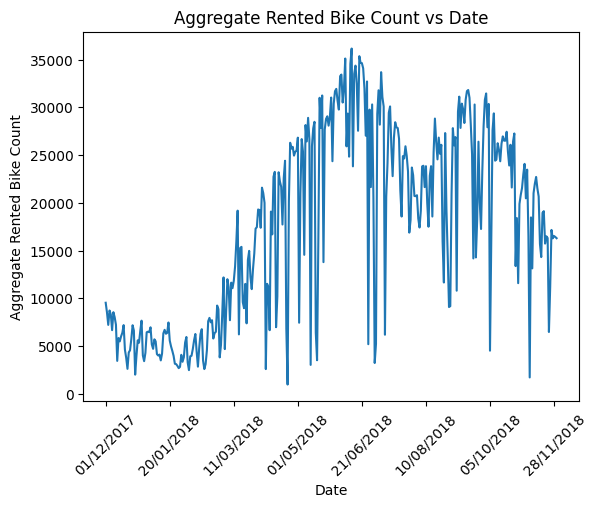

In [70]:
dailyBikeUsage.plot(kind='line')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Aggregate Rented Bike Count')
plt.title('Aggregate Rented Bike Count vs Date')

# Show the plot
plt.xticks(rotation=45)
plt.show()

### Graph of average bike usage by hour

We look at the average use by hour for the bike sharing. We see peaks relative to surrounding times at 8am and 6pm. This seems to coincide with the beginning and end of the work day. It also may coincide with times people may not be able to drive (drinking). We may look into analyzing weekends or engineering a categorical feature "isWeekend" to look at some predictibility there.

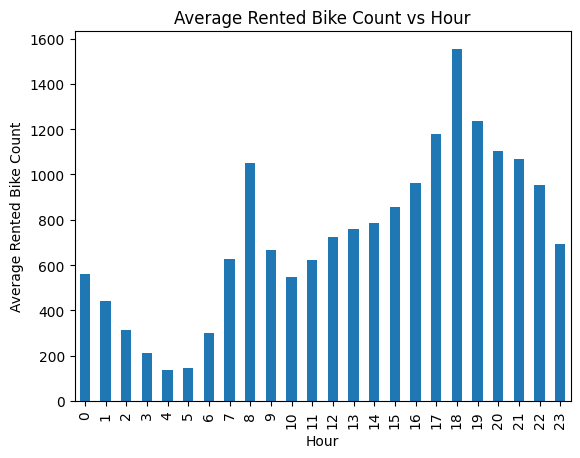

In [53]:
hourlyBikeUsage = df[df['Functioning Day'] == 'Yes'].groupby('Hour', sort=False)['Rented Bike Count'].mean()

hourlyBikeUsage.plot(kind='bar')

# Set plot labels and title
plt.xlabel('Hour')
plt.ylabel('Average Rented Bike Count')
plt.title('Average Rented Bike Count vs Hour')

# Show the plot
plt.show()

### Graphs of bike usage by season

We look at the usage per hour of the day season-by-season. We see drop off in bike usage in winter across all hours. But still see peaks and troughs of demand around the same times consistently across all seasons. Interesting, it would visually seem that winter has a lower variance, where the demand at 8am and 6pm are almost equal. This is not the case in the other seasons. We may want to create differing predictive models for each season if the behavior is different enough. This may help us provide varying estimates of demand for each season.

In other interpretations, some may argue that all seasons exhibit the same patterns. As we generally do see the same cycles of use throughout the day for each season. The only potentially interesting difference being the 8am/6pm relationship of demand in winter.

We will see if models for different seasons improve our hourly demand predictions

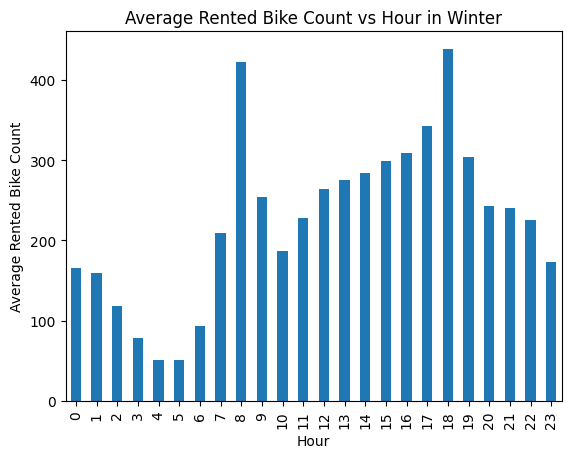

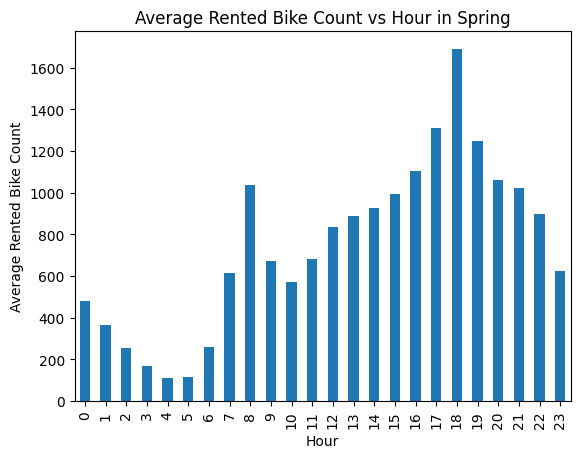

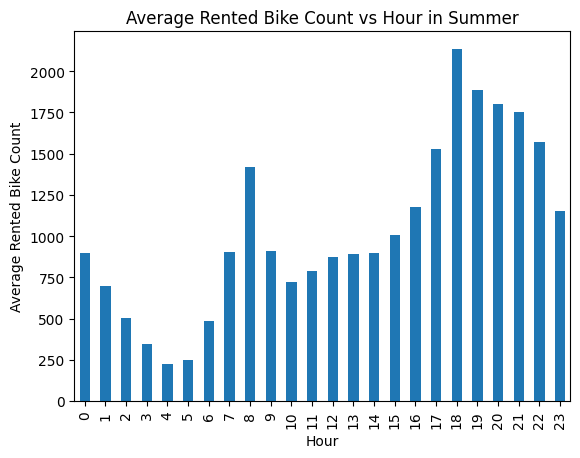

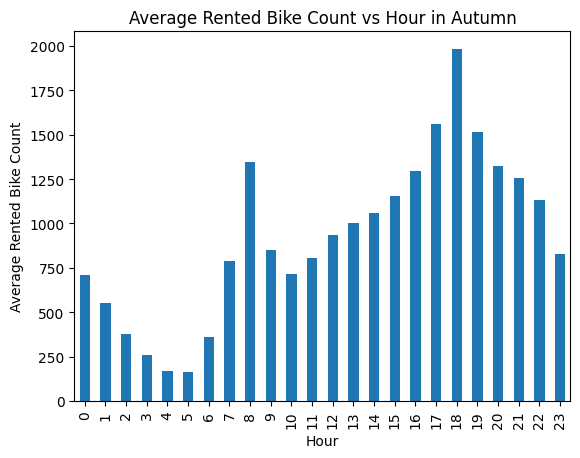

In [69]:
## takes in seasons and makes graphs
def make_graph_season(s):

  hourly_usage = df[(df['Functioning Day'] == 'Yes') & (df['Seasons'] == s)].groupby('Hour', sort=False)['Rented Bike Count'].mean()

  hourly_usage.plot(kind='bar')

  # Set plot labels and title
  plt.xlabel('Hour')
  plt.ylabel('Average Rented Bike Count')
  plt.title('Average Rented Bike Count vs Hour in ' + s)

  # Show the plot
  plt.show()

seasons = ["Winter", "Spring", "Summer", "Autumn"]

for seas in seasons:
  make_graph_season(seas)

### Correlation Matrix

As expected, we see some correlation between correlated weather events and measurements such as temperature and dew point. We may want to note these when creating our models so that we may avoid collinearity.

We see temperature, dew point (collinear with temperature), and hour most notably impacting the bike demand.

Temperature is closely related to season, so we may understand this relationship of temperature to bike demand to be related to seasons as well.

In [66]:
# creating corr matrix
non_numeric_cols = ["Date", "Holiday","Functioning Day", "Seasons"]
correlation_matrix = df[df['Functioning Day'] == "Yes"].drop(columns=non_numeric_cols).corr()

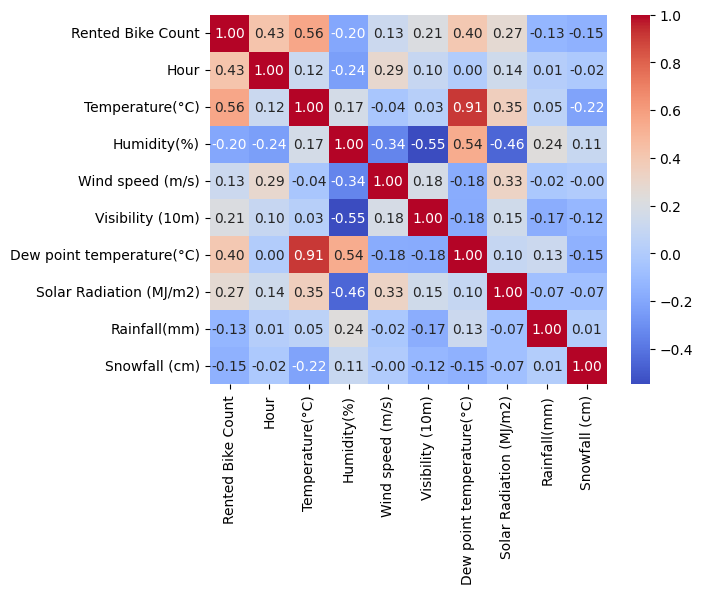

In [68]:
import seaborn as sns

# create heatmap from corr matrix for better visualisation
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

### Graphing average Rented Bike Count vs each feature

We can visualize the plots for each feature to supplement the correlation plot above.

We see when weather is fair, there is generally a higher demand for bikes.

In [99]:
def graph_vs_avg_rented_bikes(feature, df):
  output = df.groupby(feature, sort=False)['Rented Bike Count'].mean()

  if feature in ["Seasons", "Holiday"]:
    output.plot(kind='bar')
    plt.xlabel(feature)
    plt.ylabel('Average Rented Bike Count')
    plt.title('Average Rented Bike Count (hourly) vs ' + feature)

    plt.show()

  else:
    output_df = output.reset_index()

    plt.scatter(output_df[feature], output_df['Rented Bike Count'])

    plt.xlabel(feature)
    plt.ylabel('Average Rented Bike Count')
    plt.title('Average Rented Bike Count vs ' + feature)

    plt.show()




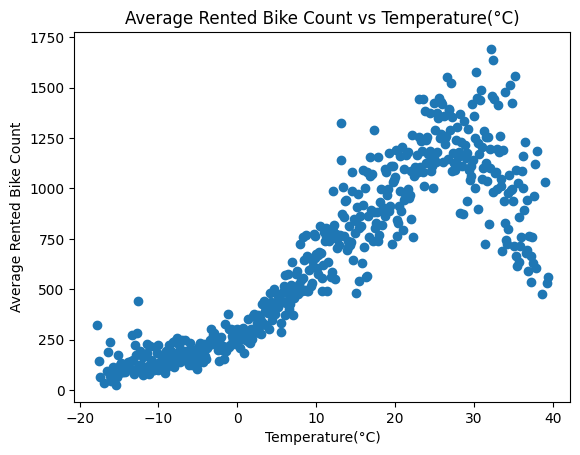

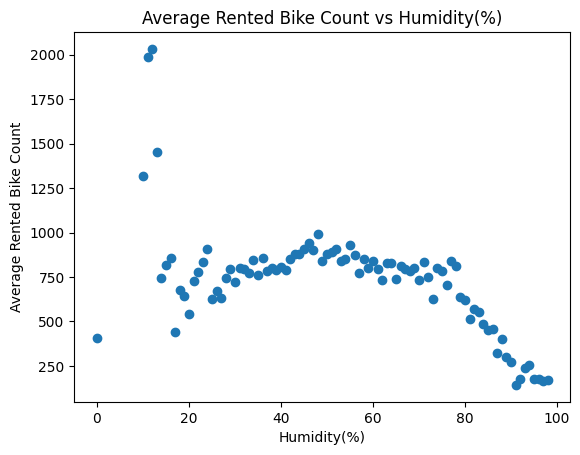

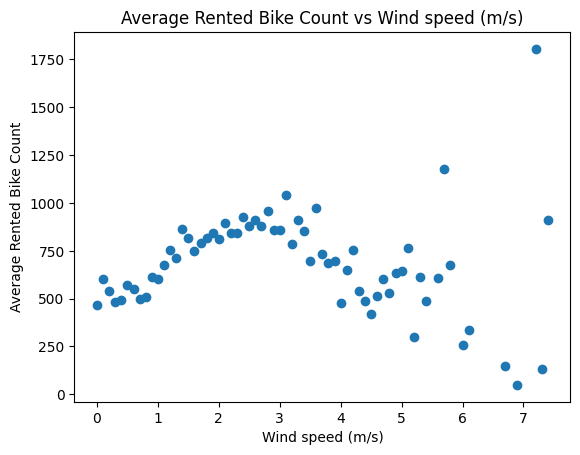

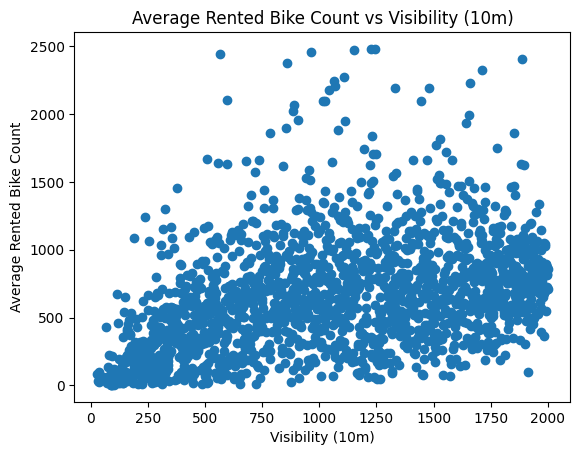

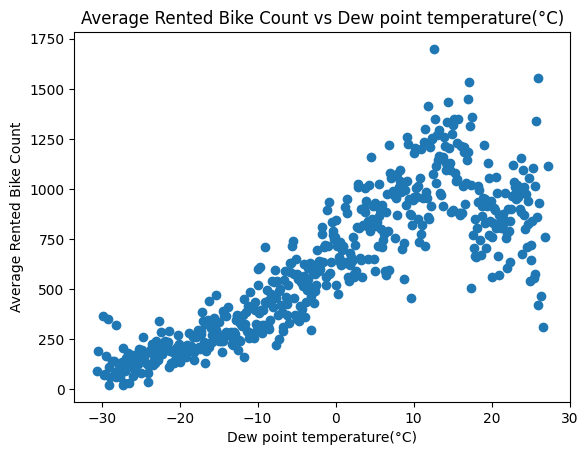

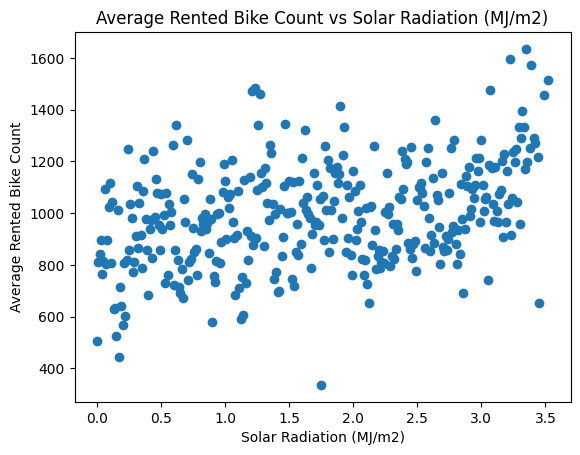

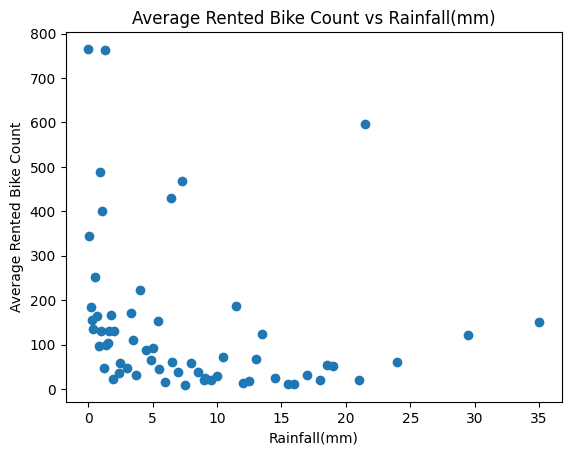

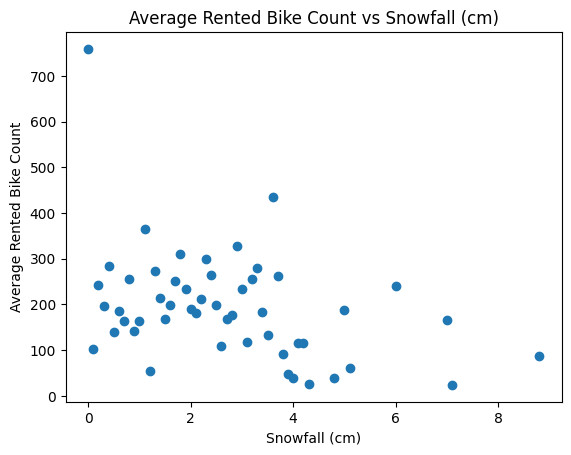

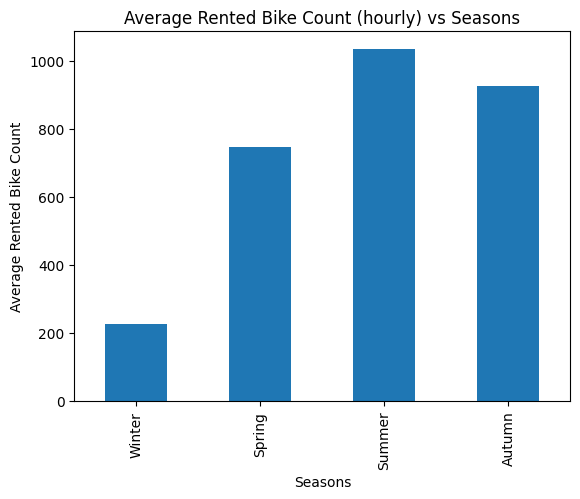

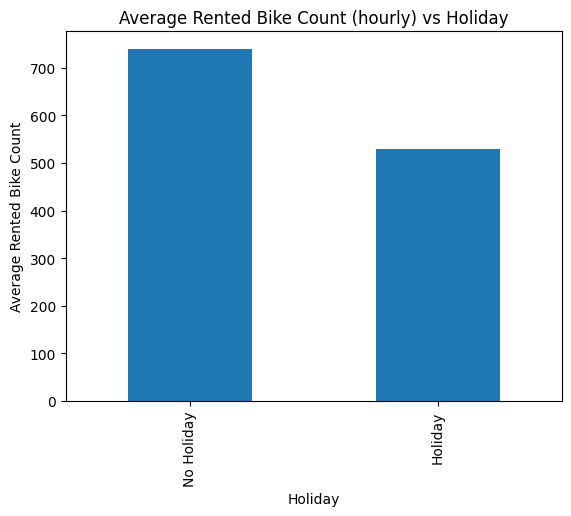

In [100]:
col_names = df.columns

for col in col_names:
  if col not in ['Date', 'Rented Bike Count', 'Hour', 'Functioning Day']:
    graph_vs_avg_rented_bikes(col, df[df['Functioning Day'] == 'Yes'])

### PCA

### UMAP